<a href="https://colab.research.google.com/github/igquinteroch/deep-learning-coursework/blob/main/A3a_DL_TC5033_A01794419.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TC 5033
## Deep Learning
## Word Embeddings

<br>

#### Activity 3a: Exploring Word Embeddings with GloVe and Numpy
<br>

### Objectives:
* To understand the concept of word embeddings and their significance in Natural Language Processing.
* To learn how to manipulate and visualize high-dimensional data using dimensionality reduction techniques like PCA and t-SNE.
* To gain hands-on experience in implementing word similarity and analogies using GloVe embeddings and Numpy.
    
<br>

### Instructions:
* Download GloVe pre-trained vectors from the provided link in Canvas, the official public project:

  Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation
  https://nlp.stanford.edu/data/glove.6B.zip

* Create a dictorionay of the embeddings so that you carry out fast look ups. Save that dictionary e.g. as a serialized file for faster loading in future uses.
    
* PCA and t-SNE Visualization: After loading the GloVe embeddings, use Numpy and Sklearn to perform PCA and t-SNE to reduce the dimensionality of the embeddings and visualize them in a 2D or 3D space.

* Word Similarity: Implement a function that takes a word as input and returns the 'n' most similar words based on their embeddings. You should use Numpy to implement this function, using libraries that already implement this function (e.g. Gensim) will result in zero points.

* Word Analogies: Implement a function to solve analogies between words. For example, "man is to king as woman is to ____". You should use Numpy to implement this function, using libraries that already implement this function (e.g. Gensim) will result in zero points.

* Submission: This activity is to be submitted in teams of 3 or 4. Only one person should submit the final work, with the full names of all team members included in a markdown cell at the beginning of the notebook.
    
<br>

### Evaluation Criteria:

* Code Quality (40%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity.
    
* Functionality (60%): All functions should work as intended, without errors
  * Visualization of PCA and t-SNE (10% each for a total of 20%)
  * Similarity function (20%)
  * Analogy function (20%)

### Import the libraries and set the stage

In [ ]:
# Import libraries
import torch
import os
import torch.nn.functional as F
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import pickle
import numpy as np
from numpy.linalg import norm
plt.style.use('ggplot')

In [ ]:
# Provides access to the Drive from within the notebook
from google.colab import drive

# Mounts the Drive into the Colab environment
drive.mount("/content/drive")

# Changes the current working directory to the specified path in Google Drive.
os.chdir("/content/drive/MyDrive/TC5033.10")

PATH = '/content/drive/MyDrive/TC5033.10/glove.6B/glove.6B.50d.txt'

Mounted at /content/drive


The below variable, `emb_dim` determines the dimensionality of the number of elements in the vectors.

It is using 50 numbers to represent each word.

In [ ]:
emb_dim = 50

The below function, `create_embedding_matrix`, transforms word embeddings stored in a dictionary into a matrix format.

It returns the `embedding_matrix`, which contains the word embeddings in a matrix form.

In [ ]:
def create_embedding_matrix(embeddings, word_i, emb_dim):
  """
  Creates an embedding matrix from a dictionary of word embeddings.

  Parameters:
    embeddings (dict): A dictionary where keys are words and values are their corresponding embedding vectors
    word_i (dict): A dictionary mapping words to their indices
    emb_dim (int): The dimensionality of the word embeddings

  Returns:
    np.ndarray: A matrix where each row represents the embedding vector for a specific word
  """

  # Get the total number of words in the vocabulary
  num_words = len(word_i)

  # Create a matrix of zeros with a size of (number of words in the vocabulary, embedding dimension)
  embedding_matrix = np.zeros((num_words, emb_dim))

  # Iterate through each word in the word_i dictionary
  for word, index in word_i.items():

      # Attempt to retrieve the embedding vector corresponding to the word
      embedding = embeddings.get(word)

      # If an embedding vector is found for the word
      if embedding is not None:

          # Assign that embedding vector to the corresponding row in the embedding matrix
          embedding_matrix[index] = embedding

  # Return the created embedding matrix
  return embedding_matrix

The below function, `create_emb_dictionary`, creates data structures from a dictionary of GloVe word embeddings.

The function basically transforms the input dictionary into a more usable format for further processing.

In [ ]:
def create_emb_dictionary(embeddings, emb_dim):
  """
  Creates a dictionary of word embeddings from a dictionary of GloVe embeddings.

  Parameters:
    embeddings (dict): A dictionary where keys are words and values are their corresponding embedding vectors
    emb_dim (int): The dimensionality of the word embeddings

  Returns:
    tuple: A tuple containing three elements:
      word_i (dict): A dictionary mapping words to their indices
      i_word (dict): A dictionary mapping indices to their corresponding words
      embedding_matrix (np.ndarray): The embedding matrix
  """

  # Extract a list of words from the provided embeddings dictionary
  words = list(embeddings.keys())

  # Create a word-to-index dictionary to map words to their corresponding indices
  word_i = {word: index for index, word in enumerate(words)}

  # Create an index-to-word dictionary to map indices back to words
  i_word = {index: word for word, index in word_i.items()}

  # Create an embedding matrix using the provided word embeddings, word-to-index mapping, and embedding dimension
  embedding_matrix = create_embedding_matrix(embeddings,word_i,emb_dim)

  # Return the word-to-index dictionary, index-to-word dictionary, and the embedding matrix
  return word_i, i_word, embedding_matrix

The below function, `load_embeddings`, loads word embeddings from the `PATH`, extracts the words and their vectors, and stores them in a Python dictionary for easy access and processing.

In [ ]:
def load_embeddings(PATH, emb_dim):
  """
  This function loads embeddings from a file into a dictionary.

  Parameters:
    PATH (str): The path to the file containing the embeddings.
    emb_dim (int): The dimensionality of the embeddings.

  Returns:
    dict: A dictionary containing the embeddings.
  """

  # Initialize an empty dictionary to store embeddings
  embeddings = {}

  # Open and read the GloVe file
  with open(PATH, 'r', encoding='utf-8') as f:
      for line in f:
          values = line.split()
          word = values[0]
          vector = np.asarray(values[1:], dtype='float32')
          # Check if the vector matches the expected dimension
          if len(vector) == emb_dim:
              embeddings[word] = vector
  return embeddings

In [ ]:
# Load and transform word embeddings into a dictonary
embeddings = load_embeddings(PATH, emb_dim)
embeddings_dict = create_emb_dictionary(embeddings, emb_dim)

### See some embeddings

In [ ]:
def show_n_first_words(PATH, n_words):
  """
  This function prints the first n words and their embeddings lengths from a file.

  Parameters:
    PATH (str): The path to the file.
    n_words (int): The number of words to print.
  """
  with open(PATH, 'r') as f:
    for i, line in enumerate(f):
      print(line.split(), len(line.split()[1:]))
      if i>=n_words: break

In [ ]:
show_n_first_words(PATH, 5)

['the', '0.418', '0.24968', '-0.41242', '0.1217', '0.34527', '-0.044457', '-0.49688', '-0.17862', '-0.00066023', '-0.6566', '0.27843', '-0.14767', '-0.55677', '0.14658', '-0.0095095', '0.011658', '0.10204', '-0.12792', '-0.8443', '-0.12181', '-0.016801', '-0.33279', '-0.1552', '-0.23131', '-0.19181', '-1.8823', '-0.76746', '0.099051', '-0.42125', '-0.19526', '4.0071', '-0.18594', '-0.52287', '-0.31681', '0.00059213', '0.0074449', '0.17778', '-0.15897', '0.012041', '-0.054223', '-0.29871', '-0.15749', '-0.34758', '-0.045637', '-0.44251', '0.18785', '0.0027849', '-0.18411', '-0.11514', '-0.78581'] 50
[',', '0.013441', '0.23682', '-0.16899', '0.40951', '0.63812', '0.47709', '-0.42852', '-0.55641', '-0.364', '-0.23938', '0.13001', '-0.063734', '-0.39575', '-0.48162', '0.23291', '0.090201', '-0.13324', '0.078639', '-0.41634', '-0.15428', '0.10068', '0.48891', '0.31226', '-0.1252', '-0.037512', '-1.5179', '0.12612', '-0.02442', '-0.042961', '-0.28351', '3.5416', '-0.11956', '-0.014533', '-0.

### Plot some embeddings

In [ ]:
def plot_embeddings(emb_path, words2show, emb_dim, embeddings_dict, func = PCA):
  """
  This function plots the embeddings of a list of words.

  Parameters:
    emb_path (str): The path to the file containing the embeddings.
    words2show (list): The list of words to plot.
    emb_dim (int): The dimensionality of the embeddings.
    embeddings_dict (dict): The dictionary containing the embeddings.
    func (function): The function to use for dimensionality reduction.

  Returns:
    np.ndarray: The embeddings of the words.
  """
  word_i, i_word, embedding_matrix = embeddings_dict

  # Get the embeddings for the specified words
  word_indices = [word_i[word] for word in words2show if word in word_i]
  embeddings_to_plot = embedding_matrix[word_indices]

  # Apply dimensionality reduction
  if func == PCA:
    pca = PCA(n_components=2)  # Reduce to 2 dimensions for plotting
    reduced_embeddings = pca.fit_transform(embeddings_to_plot)
  elif func == TSNE:
    tsne = TSNE(n_components=2, random_state=42)  # Reduce to 2 dimensions for plotting
    reduced_embeddings = tsne.fit_transform(embeddings_to_plot)
  else:
    raise ValueError("Invalid dimensionality reduction technique. Choose 'PCA' or 'TSNE'.")

  # Create the plot
  plt.figure(figsize=(10, 8))
  for i, word in enumerate(words2show):
    if word in word_i:  # Only plot words that are in the embeddings dictionary
      x, y = reduced_embeddings[i]
      plt.scatter(x, y)
      plt.annotate(word, (x, y), textcoords="offset points", xytext=(5, 5), ha='center')

  plt.title(f"Word Embeddings Visualization ({func.__name__})")
  plt.xlabel("Dimension 1")
  plt.ylabel("Dimension 2")
  plt.show()

In [ ]:
words= ['burger', 'tortilla', 'bread', 'pizza', 'beef', 'steak', 'fries', 'chips',
            'argentina', 'mexico', 'spain', 'usa', 'france', 'italy', 'greece', 'china',
            'water', 'beer', 'tequila', 'wine', 'whisky', 'brandy', 'vodka', 'coffee', 'tea',
            'apple', 'banana', 'orange', 'lemon', 'grapefruit', 'grape', 'strawberry', 'raspberry',
            'school', 'work', 'university', 'highschool']

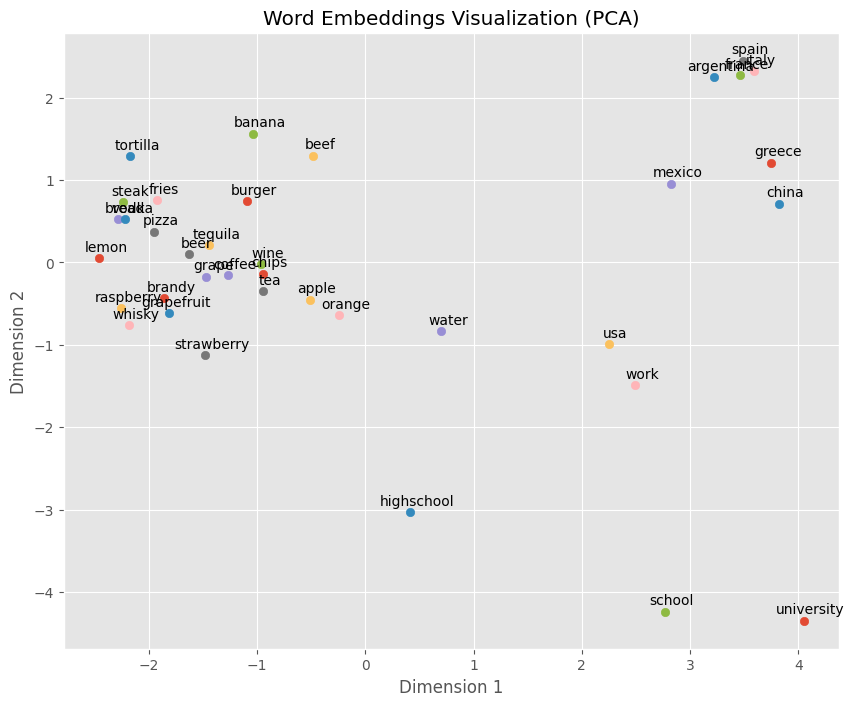

In [ ]:
# Create a visualization of word embeddings
plot_embeddings(PATH, words, emb_dim, embeddings_dict, PCA)

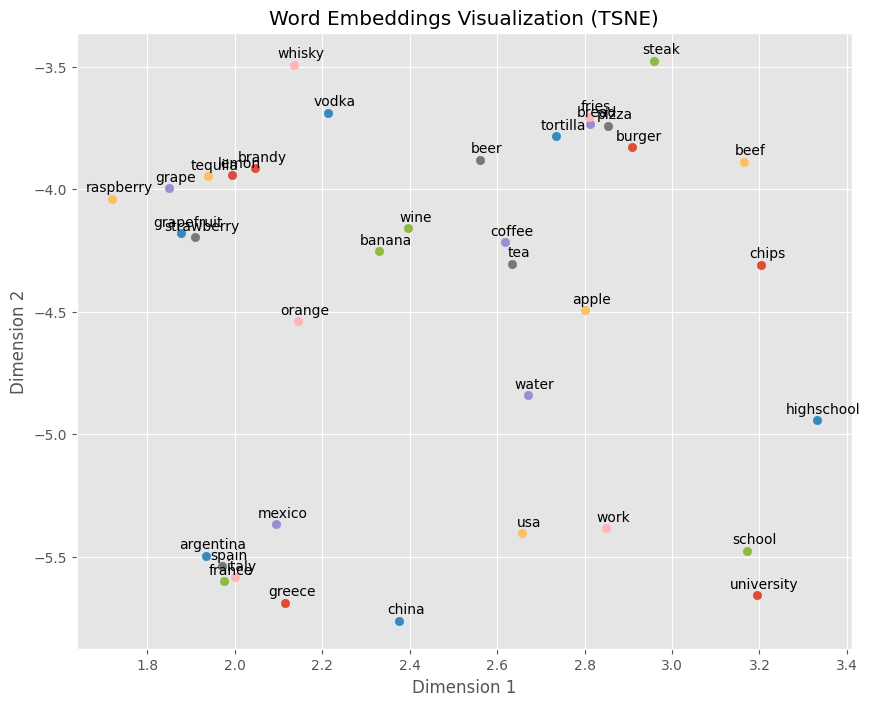

In [ ]:
# TSNE dimensionality reduction for visualization
embeddings = plot_embeddings(PATH, words, emb_dim, embeddings_dict, TSNE)

### Let us compute analogies

The following section implements the `analogy` function, which uses word embeddings to solve analogies.

It take three inputs representing the analogy and a dictionary containing word embeddings. Then, it performs vector operations on the embeddings of the input words, and searches the word embedding most similar to the analogy vector.

It finally returns the identified word.

In [ ]:
def analogy(word1, word2, word3, embeddings_dict):

  """
  This function solves word analogies using word embeddings.

  Parameters:
      word1 (str): The first word in the analogy (e.g., "man").
      word2 (str): The second word in the analogy (e.g., "king").
      word3 (str): The third word in the analogy (e.g., "woman").
      embeddings_dict (tuple): A tuple containing word-to-index, index-to-word, and embedding matrix dictionaries.

  Returns:
      str: The fourth word in the analogy (e.g., "queen").
  """
  word_i, i_word, embedding_matrix = embeddings_dict

  # Get the embeddings for the given words
  try:
    emb1 = embedding_matrix[word_i[word1]]
    emb2 = embedding_matrix[word_i[word2]]
    emb3 = embedding_matrix[word_i[word3]]
  except KeyError:
    return "Word not found in embeddings."  # Handle missing words

  # Calculate the analogy vector
  analogy_vector = emb2 - emb1 + emb3

  # Find the closest word to the analogy vector
  distances = [np.dot(analogy_vector, emb) / (norm(analogy_vector) * norm(emb))
               for emb in embedding_matrix]

  # Exclude the input words from the similarity ranking
  distances[word_i[word1]] = -1
  distances[word_i[word2]] = -1
  distances[word_i[word3]] = -1

  # Get the index of the most similar word (excluding input words)
  most_similar_index = np.argmax(distances)

  # Return the most similar word
  return i_word[most_similar_index]

In [ ]:
analogy('man', 'king', 'woman', embeddings_dict)

'queen'

### Find the most similar word

In the following section, the function `find_most_similar` uses word embeddings and cosine similarity to identify the `top_n` most similar words to a given input.

In [ ]:
def find_most_similar(word, embeddings_dict, top_n=10):
  """
  This function finds the most similar words to a given word.

  Parameters:
    word (str): The input word.
    embeddings_dict (tuple): A tuple containing word-to-index, index-to-word, and embedding matrix dictionaries.
    top_n (int): The number of most similar words to return.

  Returns:
    list: A list of tuples, where each tuple contains a similar word and its
          cosine similarity score.
  """
  word_i, i_word, embedding_matrix = embeddings_dict

  # Get the embedding for the input word
  try:
    word_emb = embedding_matrix[word_i[word]]
  except KeyError:
    return []  # Return empty list if word not found

  # Calculate cosine similarity with all other words
  similarities = []
  for i, emb in enumerate(embedding_matrix):
    similarity = np.dot(word_emb, emb) / (norm(word_emb) * norm(emb))
    similarities.append((i_word[i], similarity))

  # Sort by similarity and get top_n results
  similarities.sort(key=lambda x: x[1], reverse=True)
  most_similar = similarities[1:top_n + 1]  # Exclude the input word itself

  return most_similar

In [ ]:
most_similar = find_most_similar('chile', embeddings_dict)

In [ ]:
for i, w in enumerate(most_similar, 1):
    print(f'{i} ---> {w[0]}')

1 ---> ecuador
2 ---> venezuela
3 ---> bolivia
4 ---> uruguay
5 ---> peru
6 ---> argentina
7 ---> paraguay
8 ---> rica
9 ---> honduras
10 ---> mexico
